In [1]:
import sys
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O
import statsmodels.api as sm
from patsy import dmatrices
from sklearn.model_selection import train_test_split

# visualisation imports
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# seaborn styling default
sns.set_theme(style='darkgrid')

# hide warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_raw = pd.read_csv('derived_data/combined_dataset_2_filter.csv')
df = df_raw[['Actiwatch activity counts', 'Apple Watch ENMO', 'fileName']]
df

,Actiwatch activity counts,Apple Watch ENMO,fileName
0,0.0,0.006943,P02_N1
1,4.0,0.012221,P02_N1
2,0.0,0.006598,P02_N1
3,0.0,0.006625,P02_N1
4,0.0,0.006931,P02_N1
...,...,...,...
40655,0.0,0.004925,P17_N1
40656,0.0,0.004991,P17_N1
40657,0.0,0.004935,P17_N1
40658,0.0,0.004983,P17_N1


In [3]:
df = df.dropna()

,Actiwatch activity counts,Apple Watch ENMO,fileName
0,0.0,0.006943,P02_N1
1,4.0,0.012221,P02_N1
2,0.0,0.006598,P02_N1
3,0.0,0.006625,P02_N1
4,0.0,0.006931,P02_N1
...,...,...,...
40655,0.0,0.004925,P17_N1
40656,0.0,0.004991,P17_N1
40657,0.0,0.004935,P17_N1
40658,0.0,0.004983,P17_N1


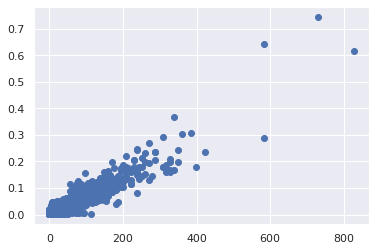

In [4]:
plt.scatter(df['Actiwatch activity counts'], df['Apple Watch ENMO'])

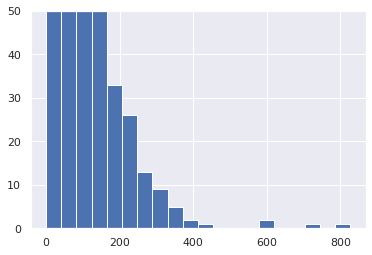

In [5]:

n_bins = 20

# Generate two normal distributions
dist1 = df['Actiwatch activity counts']
plt.ylim(0,50)
plt.hist(dist1, bins = n_bins)
plt.show()

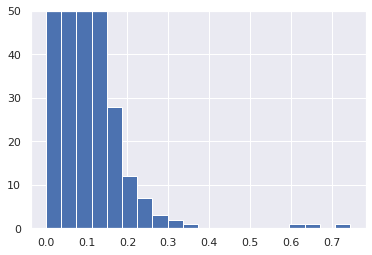

In [6]:
n_bins = 20

# Generate two normal distributions
dist1 = df['Apple Watch ENMO']
plt.ylim(0,50)
plt.hist(dist1, bins = n_bins)
plt.show()

In [7]:
#df2 = df.dropna()
nums = df.to_numpy()

In [16]:
nums

array([[0.0, 0.006943397, 'P02_N1'],
       [4.0, 0.01222079, 'P02_N1'],
       [0.0, 0.006598491, 'P02_N1'],
       ...,
       [0.0, 0.004934795, 'P17_N1'],
       [0.0, 0.0049826670000000005, 'P17_N1'],
       [0.0, 0.0052735690000000005, 'P17_N1']], dtype=object)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(nums[:, 1], nums[:, 0], test_size=0.33, random_state=42)

In [21]:
X_train = X_train.astype('float64')
y_train = y_train.astype('float64')

(0.0, 0.05)

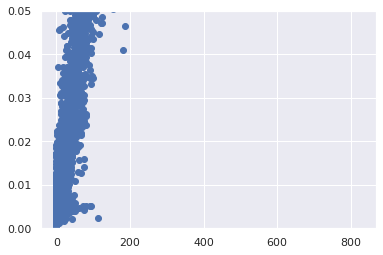

In [11]:
plt.scatter(nums[:, 0], nums[:, 1])
plt.ylim(0,.05)

In [12]:
print("Size of train X " + str(X_train.size) + " Y " + str(y_train.size) )
print("Size of test X " + str(X_test.size) + " Y " + str(y_test.size) )
print("Total size " + str(nums.size))

Size of train X 27240 Y 27240
Size of test X 13418 Y 13418
Total size 121974


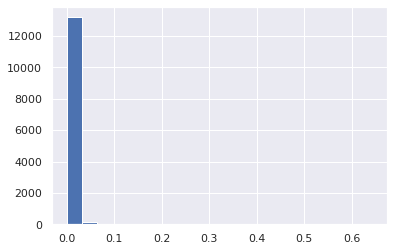

In [35]:

n_bins = 20

# Generate two normal distributions
dist1 = X_test
#plt.ylim(0,50)
plt.hist(dist1, bins = n_bins)
plt.show()

In [22]:
#fit linear regression
coef = np.polyfit(X_train,y_train,1)
poly1d_fn = np.poly1d(coef) 

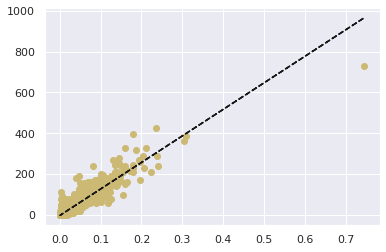

In [23]:
plt.plot(X_train,y_train, 'yo', X_train, poly1d_fn(X_train), '--k')

In [24]:
#display x and y
poly1d_fn.coef

array([1300.06557841,   -3.70231548])

array([0.00284779])

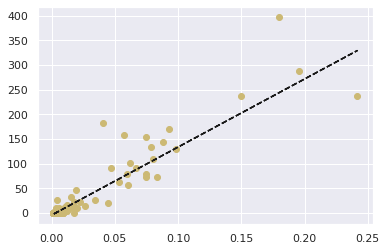

In [ ]:
plt.plot(X_test,y_test, 'yo', X_test, poly1d_fn(X_test), '--k')

In [25]:
from sklearn.linear_model import PoissonRegressor
model = PoissonRegressor()
XX_train = X_train.reshape(-1, 1)
model.fit(XX_train, y_train)

PoissonRegressor()

In [26]:
model.score(XX_train, y_train)

0.0037247874305573747

In [27]:
model.coef_

array([0.17413661])

In [28]:
pd.DataFrame(
    {"pred": model.predict(XX_train),
    "actual": y_train}
)

,pred,actual
0,2.328344,0.0
1,2.327618,0.0
2,2.327624,0.0
3,2.328051,0.0
4,2.327596,0.0
...,...,...
27235,2.328179,0.0
27236,2.328453,0.0
27237,2.329075,0.0
27238,2.328173,0.0


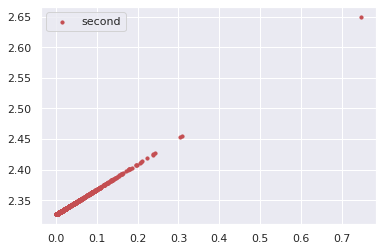

In [29]:


fig = plt.figure()
ax1 = fig.add_subplot(111)

#ax1.scatter(df['Apple Watch ENMO'] ,df['Actiwatch activity counts'], s=10, c='b', marker="s", label='first')
ax1.scatter(X_train,model.predict(XX_train), s=10, c='r', marker="o", label='second')
plt.legend(loc='upper left')
plt.show()

In [31]:
#zero inflated poisson regressio,n
zip_model = sm.Poisson(X_train, y_train, missing="drop")
zip_res = zip_model.fit()

Optimization terminated successfully.
         Current function value: 0.972538
         Iterations 9


In [34]:
zip_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:                      y   No. Observations:                27240
Model:                        Poisson   Df Residuals:                    27239
Method:                           MLE   Df Model:                            0
Date:                Sun, 25 Sep 2022   Pseudo R-squ.:                  -35.01
Time:                        16:02:06   Log-Likelihood:                -26492.
converged:                       True   LL-Null:                       -735.66
Covariance Type:            nonrobust   LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0591      0.003    -19.137      0.000      -0.065      -0.053
==============================================================================
"""

In [33]:
dist = zip_model.distribution(mu=zip_res.params[1], w=zip_res.params[0])
dist.pmf(1)

AttributeError: 'Poisson' object has no attribute 'distribution'

In [ ]:
dist.pmf(5)

nan

In [ ]:
zip_predictions = zip_training_results.predict(df['Actiwatch activity counts'])

In [ ]:
predicted_counts=np.round(zip_predictions)

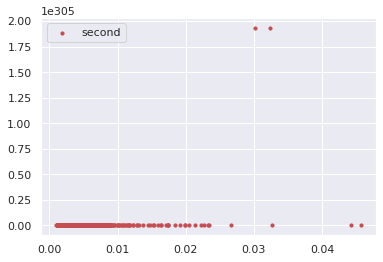

In [ ]:


fig = plt.figure()
ax1 = fig.add_subplot(111)

#ax1.scatter(df['Apple Watch ENMO'] ,df['Actiwatch activity counts'], s=10, c='b', marker="s", label='first')
ax1.scatter(df['Apple Watch ENMO'],predicted_counts, s=10, c='r', marker="o", label='second')
plt.legend(loc='upper left')
plt.show()

In [ ]:
pd.DataFrame({"x": df["Apple Watch ENMO"], "y": df["Actiwatch activity counts"], "y_pred": predicted_counts})

,x,y,y_pred
0,0.007234,0.0,0.000000e+00
1,0.030109,24.0,1.934922e+305
2,0.008785,3.0,1.392287e+37
3,0.007893,0.0,0.000000e+00
4,0.007761,3.0,1.392287e+37
...,...,...,...
3171,0.001742,0.0,0.000000e+00
3172,0.001455,0.0,0.000000e+00
3173,0.001397,0.0,0.000000e+00
3174,0.082055,144.0,inf
